Notebook to Test gsw TEOS conversion instead of Matlab

In [1]:
import gsw
import matplotlib.pyplot as plt
import netCDF4 as nc

from salishsea_tools import gsw_calls
from salishsea_tools import LiveOcean_BCs as nancy

%matplotlib inline

In [38]:
sal_matlab = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_y2018m11d08.nc')

In [42]:
sal_gsw = nc.Dataset('single_LO_y2018m11d09.nc')

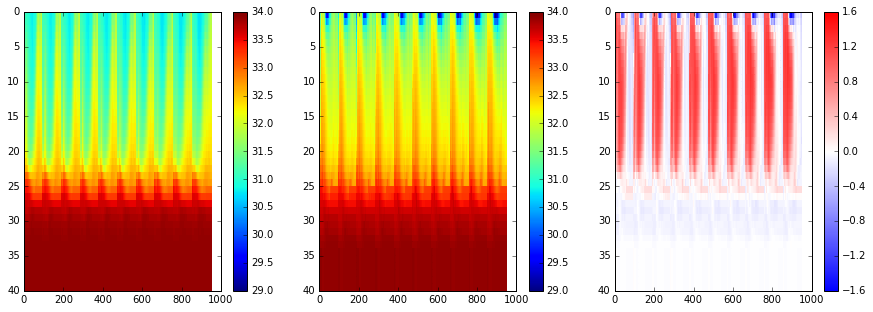

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh0 = axs[0].pcolormesh(sal_matlab['vosaline'][0, :, 0, :], vmin=29, vmax=34)
mesh1 = axs[1].pcolormesh(sal_gsw['vosaline'][0, :, 0, :], vmin=29, vmax=34)
mesh2 = axs[2].pcolormesh(sal_gsw['vosaline'][0, :, 0, :] - sal_matlab['vosaline'][0, :, 0, :], cmap='bwr', 
                         vmax=1.6, vmin=-1.6)
fig.colorbar(mesh0, ax=axs[0])
fig.colorbar(mesh1, ax=axs[1])
fig.colorbar(mesh2, ax=axs[2])
for ax in axs:
    ax.invert_yaxis()

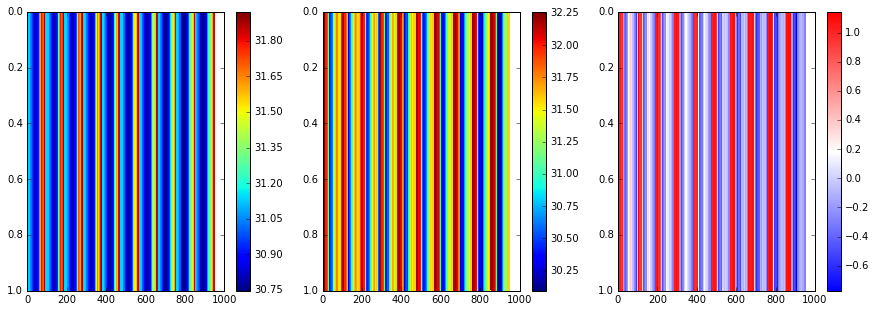

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh0 = axs[0].pcolormesh(sal_matlab['vosaline'][0, 1, :, :])
mesh1 = axs[1].pcolormesh(sal_gsw['vosaline'][0, 1, :, :])
mesh2 = axs[2].pcolormesh(sal_gsw['vosaline'][0, 1, :, :] - sal_matlab['vosaline'][0, 1, :, :], cmap='bwr', 
                         )
fig.colorbar(mesh0, ax=axs[0])
fig.colorbar(mesh1, ax=axs[1])
fig.colorbar(mesh2, ax=axs[2])
for ax in axs:
    ax.invert_yaxis()

# Dig Deeper

In [2]:
depBC, lonBC, latBC, shape = nancy.load_SalishSea_boundary_grid(imin=376-1, imax=470, rim=10, 
                                                          meshfilename='/home/sallen/MEOPAR/grid/mesh_mask201702.nc')

In [3]:
# Create metadeta for temperature and salinity (Live Ocean variables, NEMO grid)
var_meta = {'vosaline': {'grid': 'SalishSea2',
                             'long_name': 'Practical Salinity',
                             'units': 'psu'},
                'votemper': {'grid': 'SalishSea2',
                             'long_name': 'Potential Temperature',
                             'units': 'deg C'},
                'NO3':      {'grid': 'SalishSea2',
                             'long_name': 'Nitrate',
                             'units': 'muM'},
                'Si':       {'grid': 'SalishSea2',
                             'long_name': 'Nitrate',
                             'units': 'muM'},
                'OXY':      {'grid': 'SalishSea2',
                             'long_name': 'Oxygen',
                             'units': 'muM'},
                'DIC':      {'grid': 'SalishSea2',
                             'long_name': 'Dissolved Inorganic Carbon',
                             'units': 'muM'},
                'TA':       {'grid': 'SalishSea2',
                             'long_name': 'Total Alkalinity',
                             'units': 'muM'},
                }

# Mapping from LiveOcean TS names to NEMO TS names
LO_to_NEMO_var_map = {'salt': 'vosaline',
                          'temp': 'votemper',
                          'NO3': 'NO3',
                          'Si': 'Si',
                      'oxygen': 'OXY',
                         'TIC': 'DIC',
                  'alkalinity': 'TA',}

In [4]:
date = '2018-11-08'
d = nancy.load_LiveOcean(date)

In [5]:
interps = nancy.interpolate_to_NEMO_depths(d, depBC, var_names=(var for var in LO_to_NEMO_var_map if var != 'Si'))

In [6]:
sal_ref = gsw.SR_from_SP(interps['salt'])

In [7]:
mat_sal_ref = gsw_calls.generic_gsw_caller('gsw_SR_from_SP.m', [
        interps['salt'][:],
    ])
mat_sal_ref.shape

(40, 31, 26)

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


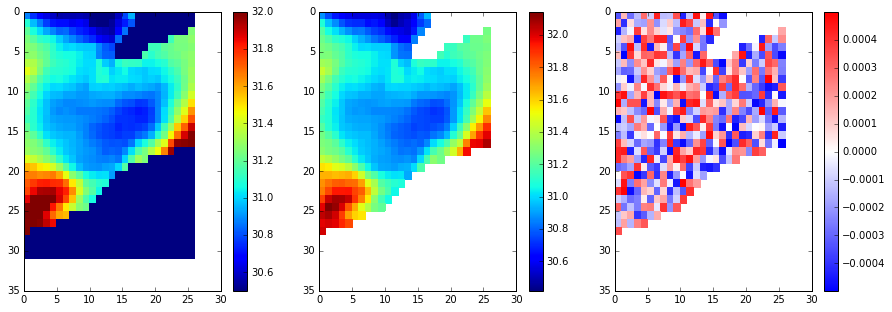

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh0 = axs[0].pcolormesh(mat_sal_ref[1, :, :], vmax=32, vmin=30.5)
mesh1 = axs[1].pcolormesh(sal_ref[1, :, :])
mesh2 = axs[2].pcolormesh(sal_ref[1, :, :] - mat_sal_ref[1, :, :], cmap='bwr')
fig.colorbar(mesh0, ax=axs[0])
fig.colorbar(mesh1, ax=axs[1])
fig.colorbar(mesh2, ax=axs[2])
for ax in axs:
    ax.invert_yaxis()

In [10]:
temp_cons = gsw.CT_from_pt(sal_ref[:], interps['temp'])

In [11]:
mat_temp_cons = gsw_calls.generic_gsw_caller(
        'gsw_CT_from_pt.m', [
            mat_sal_ref,
           interps['temp'] ,
        ]
    )

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


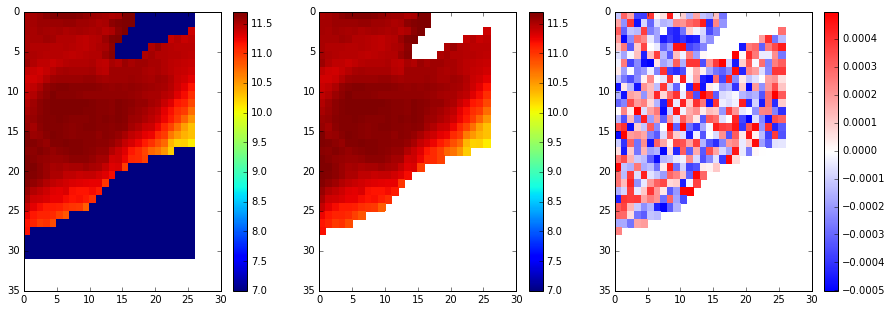

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh0 = axs[0].pcolormesh(mat_temp_cons[1, :, :], vmax=7., vmin=11.7)
mesh1 = axs[1].pcolormesh(temp_cons[1, :, :], vmax=7., vmin=11.7)
mesh2 = axs[2].pcolormesh(temp_cons[1, :, :] - mat_temp_cons[1, :, :], cmap='bwr')
fig.colorbar(mesh0, ax=axs[0])
fig.colorbar(mesh1, ax=axs[1])
fig.colorbar(mesh2, ax=axs[2])
for ax in axs:
    ax.invert_yaxis()

In [13]:
interps['salt'] = sal_ref
interps['temp'] = temp_cons
interps = nancy.remove_south_of_Tatoosh(interps)

In [14]:
mat_interps = interps.copy()
mat_interps['salt'] = mat_sal_ref
mat_interps['temp'] = mat_temp_cons
mat_interps = nancy.remove_south_of_Tatoosh(mat_interps)

In [15]:
interps = nancy.fill_box(interps)
mat_interps = nancy.fill_box(mat_interps)

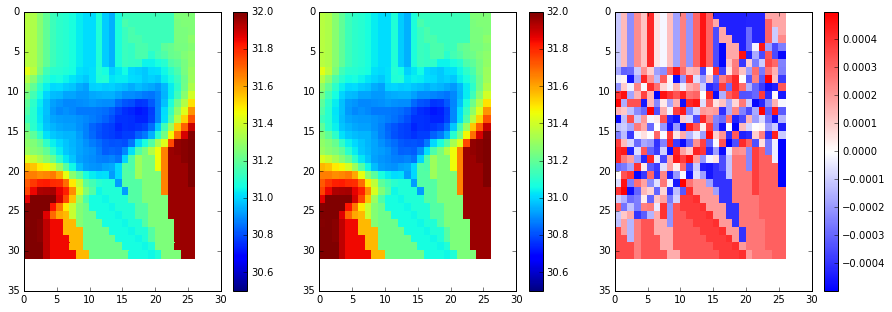

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh0 = axs[0].pcolormesh(mat_interps['salt'][1, :, :], vmax=32, vmin=30.5)
mesh1 = axs[1].pcolormesh(interps['salt'][1, :, :], vmax=32, vmin=30.5)
mesh2 = axs[2].pcolormesh(interps['salt'][1, :, :] - mat_interps['salt'][1, :, :], cmap='bwr',)
fig.colorbar(mesh0, ax=axs[0])
fig.colorbar(mesh1, ax=axs[1])
fig.colorbar(mesh2, ax=axs[2])
for ax in axs:
    ax.invert_yaxis()

In [18]:
sigma = gsw.sigma0(interps['salt'][:], interps['temp'][:] )

In [19]:
mat_sigma = gsw_calls.generic_gsw_caller('gsw_sigma0.m', [mat_interps['salt'][:], mat_interps['temp'][:] ])

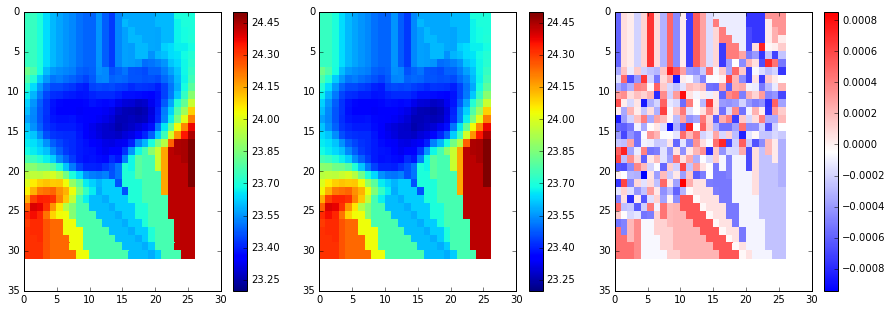

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh0 = axs[0].pcolormesh(mat_sigma[1, :, :],vmax=24.5, vmin=23.2)
mesh1 = axs[1].pcolormesh(sigma[1, :, :], vmax=24.5, vmin=23.2)
mesh2 = axs[2].pcolormesh(sigma[1, :, :] - mat_sigma[1, :, :], cmap='bwr')
fig.colorbar(mesh0, ax=axs[0])
fig.colorbar(mesh1, ax=axs[1])
fig.colorbar(mesh2, ax=axs[2])
for ax in axs:
    ax.invert_yaxis()

In [23]:
sigma, interps = nancy.convect(sigma, interps)

In [24]:
mat_sigma, mat_interps = nancy.convect(mat_sigma, mat_interps)

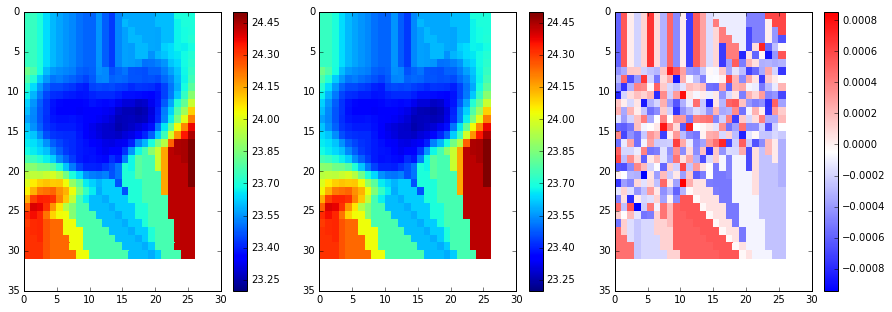

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh0 = axs[0].pcolormesh(mat_sigma[1, :, :],vmax=24.5, vmin=23.2)
mesh1 = axs[1].pcolormesh(sigma[1, :, :], vmax=24.5, vmin=23.2)
mesh2 = axs[2].pcolormesh(sigma[1, :, :] - mat_sigma[1, :, :], cmap='bwr')
fig.colorbar(mesh0, ax=axs[0])
fig.colorbar(mesh1, ax=axs[1])
fig.colorbar(mesh2, ax=axs[2])
for ax in axs:
    ax.invert_yaxis()

In [26]:
interps = nancy.extend_to_depth(interps)

In [27]:
mat_interps = nancy.extend_to_depth(mat_interps)

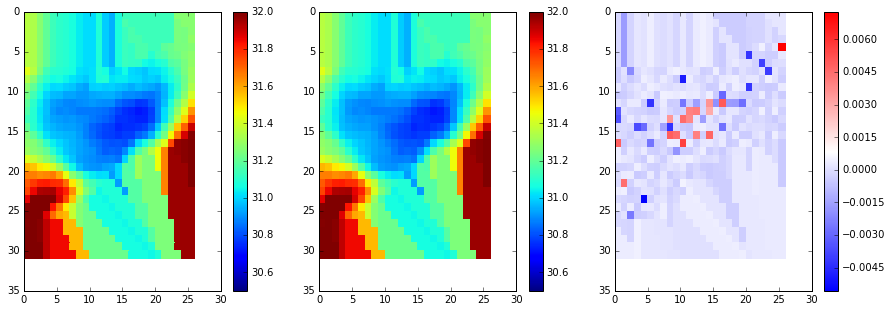

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh0 = axs[0].pcolormesh(mat_interps['salt'][1, :, :], vmax=32, vmin=30.5)
mesh1 = axs[1].pcolormesh(interps['salt'][1, :, :], vmax=32, vmin=30.5)
mesh2 = axs[2].pcolormesh(interps['salt'][1, :, :] - mat_interps['salt'][1, :, :], cmap='bwr')
fig.colorbar(mesh0, ax=axs[0])
fig.colorbar(mesh1, ax=axs[1])
fig.colorbar(mesh2, ax=axs[2])
for ax in axs:
    ax.invert_yaxis()

In [30]:
interpl = nancy.interpolate_to_NEMO_lateral(interps, d, lonBC, latBC, shape)
interpl['salt'].shape

(40, 95, 10)

In [31]:
mat_interpl = nancy.interpolate_to_NEMO_lateral(mat_interps, d, lonBC, latBC, shape)

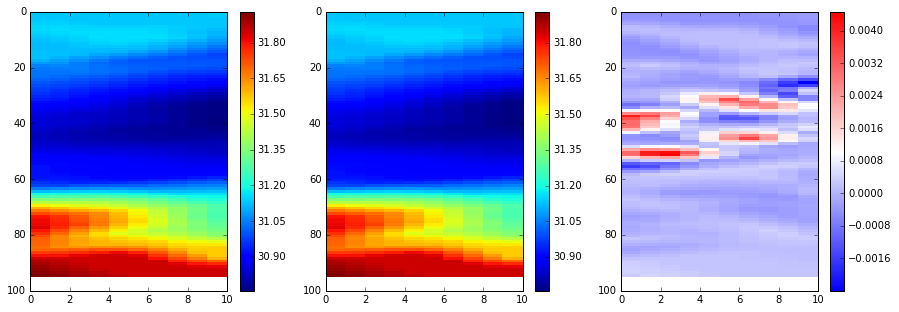

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh0 = axs[0].pcolormesh(mat_interpl['salt'][1, :, :],)
mesh1 = axs[1].pcolormesh(interpl['salt'][1, :, :], )
mesh2 = axs[2].pcolormesh(interpl['salt'][1, :, :] - mat_interpl['salt'][1, :, :], cmap='bwr')
fig.colorbar(mesh0, ax=axs[0])
fig.colorbar(mesh1, ax=axs[1])
fig.colorbar(mesh2, ax=axs[2])
for ax in axs:
    ax.invert_yaxis()